# Modèles de courbe de taux

Cheryl KOUADIO  
2025-03-04

## I. Reconstitution de la courbe de taux

### I.1. Formules de valorisation des taux de marché

La courbe interbancaire est une courbe de taux qui représente les taux
d’intérêt auxquels les banques se prêtent de l’argent entre elles. Elle
est utilisée pour déterminer les taux d’intérêt des prêts et des
emprunts à court terme. Elle est construite sur le court terme
(maturité\<6M) à partir des taux du marchés monétaire (Money Market)
basés sur les dépots non garantis entre banques. Sur le moyen terme
(6m - 3y) elle est construite à partir des contrats futures, i.e. des
forwards sur un marché OTC (Over The Counter) et sur le long terme
(\>3y) elle est construite à partir des contrats de swap euribor (Euro
Interbank Offered Rate) 3M ou 6M.

Ci dessous, nous disposons de ces données de taux de marché cotés sur le
marché interbancaire. Nous allons essayer de reconstituer la courbe de
taux zero coupon implicite, qui ne cote pas directement sur le marché.
Le fichier de données contient trois variables : - Type d’instruments
(Money Market, Futures, Swap) - Maturité (en années) - Taux d’intérêt

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = pd.read_excel('data/Data_tx.xlsx', sheet_name='tx_marche')
data.columns = ['type', 'T', 'tx']
data

En l’absence d’oppotunité d’arbitrage, les valorisations des instruments
de marché s’expriment en fonction des taux zéro coupon implicites
suivantes : - Sur le segment **Money Market**, on cote en taux
monétaires :

    $$
    L_t(T,T+\delta) = \frac{1}{\delta} \left( \frac{B(t,T)}{B(t,T+\delta)} - 1 \right),
    $$

    avec t le temps courant, T la maturité et $\delta$ la période de capitalisation.
    Dans notre cas, t=T=0 et $\delta$ varie en fonction de la maturité.

-   Sur le segment **Future**, on côte en 1 - tx forward :

    $$
      future(T, T+\delta) = 1 - L_t(T,T+\delta).
      $$ Dans notre cas, t=0, T= maturité - 3m et $\delta = 3m$.

-   Sur le segment **Swap**, on côte en taux swap :

    $$
      Swap(t, T_0, T_n) = B(t, T_0)−B(t, T_n)−K ×lvl(t),
      $$

    avec K le taux fixe du swap qui égalise la PV du swap vaut 0 et
    $lvl(t)=\sum_{i=1}^{n} \delta_i B(t, T_i)$ le taux de marché à la
    maturité $T_n$. Dans notre cas, la date de départ est le spot,
    i.e. $T_0=0$ et $T_n$ est la maturité du swap, et t=0 (vu
    d’aujourd’hui).

De ce fait, le données ne sont pas homogènes en taux du fait de la
différente cotations des instruments. Nous allons donc les transformer
en taux monétaires pour les homogénéiser.

**Remarques préliminaires** : - En zone EURO, les swaps standards côtés
sur le marché ont une fréquence de paiement semestrielle pour la patte
variable et annuelle pour la patte fixe. Ainsi pour le calcul du level
du swap, $\delta=1$ et on ajoute progressivement les taux de marché. -
Pour simplifier les calculs, nous supposerons que les dates de départ
des taux monétaires et des taux de swap sont spot (i.e. T0 = 0 et non 1
ou 2 jours).

**Methode de bootstrapping & stripping** :

Pour extraire les taux zéro coupon implicites, nous allons utiliser la
méthode de bootstrapping. Cette méthode consiste à calculer les taux
zéro coupon implicites à partir des taux de marché. Pour cela, nous
allons utiliser les formules des taux monétaires présentées ci-dessus,
qui sont vu comme des fonctions de taux zéro coupon implicites.

Comme les taux de swap ne sont pas nécessairement disponibles pour
toutes les maturités annuelles, il faut interpoler les taux
intermédiaires. Cela permettra de simplifier la méthode de
bootstrapping. Nous allons utiliser une interpolation par spline cubic
afin d’avoir des taux swap par an. Une interpolation par spline permet
d’avoir des bonnes propriétés en terme de dérivabilité et de continuité
de la courbe de taux.

Il s’agira donc de construire une nouvelle courbe de taux de marché
discrète avec des cotations annuelles de taux swap à l’aide d’une
méthode d’interpolation par spline, en plus des autres instruments. Par
la suite, on supposera que cette nouvelle courbe est la courbe de marché
de référence, i.e. la courbe utilisée pour impliciter les taux zéro
coupon.

Enfin, nous allons faire du stripping afin de reconstituer une courbe de
taux zero coupon implicite plus lisse à l’aide de différentes méthodes
d’interpolations (linéaire, spline, etc).

### I.2. Construction de la courbe des taux zéro-coupon

In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def interpolate_and_update_df(data, col_x, col_y, kind='cubic', start=3, end=30, step=1):
    """
    Interpole les taux SWAP et met à jour le DataFrame avec les nouvelles valeurs interpolées.

    Paramètres :
    - data : DataFrame d'origine contenant une colonne 'type' avec 'SWAP', 'T' et 'tx'.
    - kind : Type d'interpolation (par défaut 'cubic', peut être 'linear', 'quadratic', etc.).
    - start : Valeur minimale de T pour l'interpolation (par défaut 3).
    - end : Valeur maximale de T pour l'interpolation (par défaut 31).
    - step : Pas d'incrémentation pour la grille interpolée (par défaut 1).

    Retourne :
    - new_df : DataFrame mis à jour avec les taux SWAP interpolés.
    """

    data = data.copy()
    x, y = data[col_x].values, data[col_y].values

    f = interp1d(x, y, kind=kind)
    xnew = np.arange(start, end+step, step)
    tx_new = f(xnew)
    df = pd.DataFrame({col_x: xnew, col_y: tx_new})

    return df

df_interp = interpolate_and_update_df(data, 'T', 'tx') 
df_interp['type'] = 'SWAP'
df_interp.head()

In [4]:
# Le rajoiuter dans le df
new_df = pd.concat([data[data["type"] != "SWAP"], df_interp], ignore_index=True)
new_df.head()

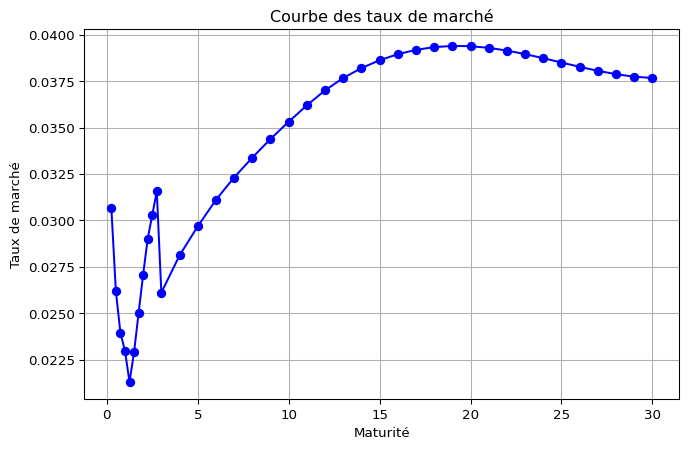

In [5]:
# Affichage d'une courbe homogène de taux de marché en fonction de la maturité
new_df['tx_h'] = new_df.apply(lambda x: 1 - x['tx'] if x['type'] == 'FUT' else x['tx'], axis=1)

plt.figure(figsize=(8, 5))
plt.plot(new_df["T"], new_df["tx_h"], marker='o', linestyle='-', color='b')
plt.xlabel('Maturité')
plt.ylabel('Taux de marché')
plt.title('Courbe des taux de marché')
plt.grid()
plt.show()

#### Extraction du taux zero coupon sur le segment Money Market

Les taux zéro-coupon continus sont définis par la formule suivante :

$$
r(t,T) = -\frac{1}{T-t} \ln B(t,T),
$$

où B(t,T) est le facteur d’actualisation
($B(t,T) = exp(-r(t,T) \times  T)$ ), i.e. le prix d’une obligation
zéro-coupon de maturité T à la date t.

Ils sont la brique de base pour la valorisation des produits dérivés et
des obligations. De ce fait, nous allons essayer de reconstituer la
courbe des taux zéro-coupon implicite à partir de la courbe des taux de
marché à l’aide de la méthode du bootstrapping. Cette méthode consiste à
calculer les taux zéro-coupon implicites à partir des taux de marché en
utilisant la formule suivante selon le segment Money Market :

$$
L_0(0,\delta) = \frac{1}{\delta} \left( \frac{1}{B(0,\delta)} - 1 \right)
$$

De ce fait, le facteur d’actualisation est : $$
B(0,\delta) = \frac{1}{1 + \delta L_0(0,\delta)}
$$

In [6]:
# Extraction des facteurs d'actualisation pour les Money Market
mm = new_df[new_df['type'] == 'MM']

mm.loc[:, 'B'] = 1 / (1 + mm['tx'] * mm['T'])
mm.loc[:, 'R'] = - np.log(mm['B']) / mm['T']

df_ZC = mm

#### Extraction du taux zero coupon sur le segment Future

Sur le segment Future, on a :

$$
Future = 1 - L_0(T,T+\delta) = 1 - \frac{1}{\delta} \left( \frac{B(0,T)}{B(0,T+\delta)} - 1 \right)
$$

De ce fait, le facteur d’actualisation est : $$
B(0,T+\delta) = \frac{B(0,T)}{1 + \delta (1- Future)}
$$

In [7]:
# Extraction des facteurs d'actualisation pour les Futures

fut = new_df[new_df['type'] == 'FUT']

# concat à mm
df_ZC = pd.concat([df_ZC, fut], ignore_index=True)

mm_len = len(mm)

for i in range(mm_len, len(df_ZC)):
    df_ZC.loc[i, 'B'] = df_ZC.loc[i-1, 'B'] / (1 + (1 - df_ZC.loc[i, 'tx'])* 0.25)
    df_ZC.loc[i, 'R'] = - np.log(df_ZC.loc[i, 'B']) / df_ZC.loc[i, 'T']

#### Extraction du taux zero coupon sur le segment swap

Pour le segment swap payeur, on a :

$$
Swap(t, T_0, T_n) = B(t, T_0)−B(t, T_n)−K ×lvl(t) = 0,
$$

avec K le taux fixe du swap qui fait que la PV du swap vaut 0 et
$lvl(t)=\sum_{i=1}^{n} \delta_i B(t, T_i)$ le taux de marché à la
maturité $T_n$. De ce fait, le facteur d’actualisation est : $$
B(0,T_n) = \frac{1 - K \sum_{i=1}^{n-1} \delta_i B(0,T_i)}{1 + K}
$$

In [8]:
# Extraction des facteurs d'actualisation pour les Swaps
swap = new_df[new_df['type'] == 'SWAP']
fut_len = len(fut)

df_ZC = pd.concat([df_ZC, swap], ignore_index=True)

for i in range(mm_len+fut_len, len(df_ZC)):
    T_n = df_ZC.loc[i, 'T']  # Récupère la valeur de T actuelle
    mask = (df_ZC['T'] < T_n) & (df_ZC['T'] % 1 == 0)  # Sélectionne uniquement les T entiers < T_n
    df_ZC.loc[i, 'B'] = (1 - df_ZC.loc[i, 'tx'] * sum(df_ZC.loc[mask, 'B'].fillna(0)))/(1+df_ZC.loc[i, 'tx'])
    df_ZC.loc[i, 'R'] = - np.log(df_ZC.loc[i, 'B']) / T_n

Text(0.5, 1.0, 'Courbe de taux zéro coupon discrétisée')

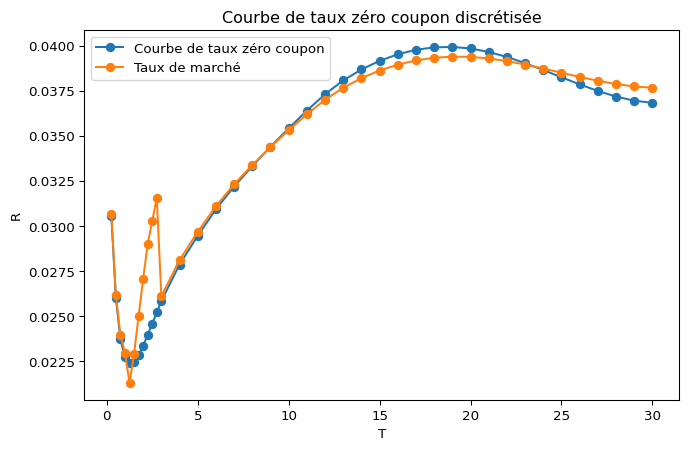

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(df_ZC['T'], df_ZC['R'], label='Courbe de taux zéro coupon', marker='o')
plt.plot(new_df["T"], new_df["tx_h"], label='Taux de marché', marker='o')
plt.xlabel('T')
plt.ylabel('R')
plt.legend()
plt.title('Courbe de taux zéro coupon discrétisée')

Comme on peut le constater, le mode d’interpolation a un impact
significatif sur le calcul des taux de marché car il affecte la forme de
la courbe des taux et donc la valorisation des instruments financiers.

### I.3. Construction de la courbe des taux forward

A partir de la courbe des taux zéro-coupon issue de la méthode de
bootstrapping, nous souhaitons tracer la courbe des taux forwards de
tenor 3M en fonction de la maturité à l’aide des méthodes
d’interpolation linéaire et par spline, avec une discrétisation de 0.1
an.

Pour tracer la courbe taux forward, on utilisera la formule suivante
pour calculer les taux forward :

$$
L_0(T,T+\delta) = \frac{1}{\delta} (\frac{B(0,T)}{B(0,T+\delta)} - 1)
$$ avec $\delta = 0.25$.

Pour le segment swap, il s’agira d’interpoler les taux zéro-coupon
implicites pour avoir des tx forwards 3M. \# changer la discretisatio à
1an ce qui est différent du ténor.

In [10]:
df_ZC = pd.concat([pd.DataFrame({"T": [0], "B": [1], "R": [0]}), df_ZC], ignore_index=True)

Text(0.5, 1.0, 'Courbe des taux forward avec interpolation linéaire')

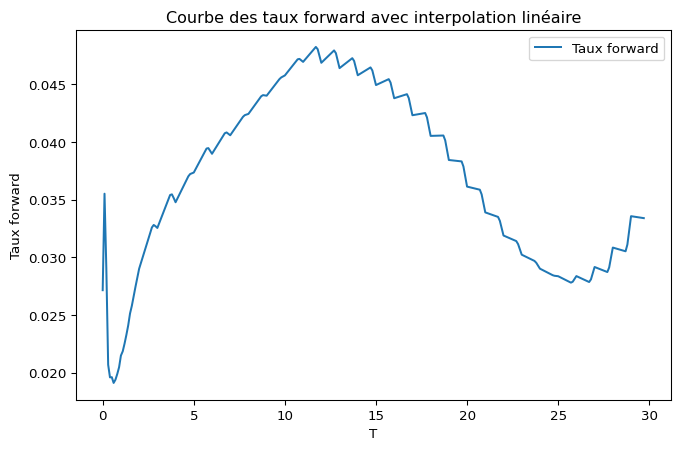

In [11]:
new_df_ZC= interpolate_and_update_df(df_ZC, 'T', 'R', kind='linear', start=0, end=30, step=0.1)

tau = 0.25  # 3 mois = 0.25 an

def compute_forward_rates(R, T_range, tau):
    """ Calcule les taux forward pour chaque maturité """
    fwd_rates = []
    T_values = []
    for i in range(len(T_range)-1):
        T = T_range[i]
        T_tau = T + tau
        if T_tau >= max(T_range):
            break  # Éviter d'extrapoler au-delà des données disponibles
        B_T = np.exp(-R[i] * T)
        R_T_tau = np.interp(T_tau, T_range, R) 
        B_T_tau = np.exp(-R_T_tau * T_tau)

        # Formule du taux forward instantané
        fwd_rate = (B_T / B_T_tau - 1) / tau
        fwd_rates.append(fwd_rate)
        T_values.append(T)

    return pd.DataFrame({"T": T_values, "tx_fwd": fwd_rates})

fwd_rates = compute_forward_rates(new_df_ZC['R'], new_df_ZC['T'], tau)

plt.figure(figsize=(8, 5))
plt.plot(fwd_rates["T"],fwd_rates["tx_fwd"], label='Taux forward')
plt.xlabel('T')
plt.ylabel('Taux forward')
plt.legend()
plt.title('Courbe des taux forward avec interpolation linéaire')

Text(0.5, 1.0, 'Courbe des taux forward avec interpolation par spline')

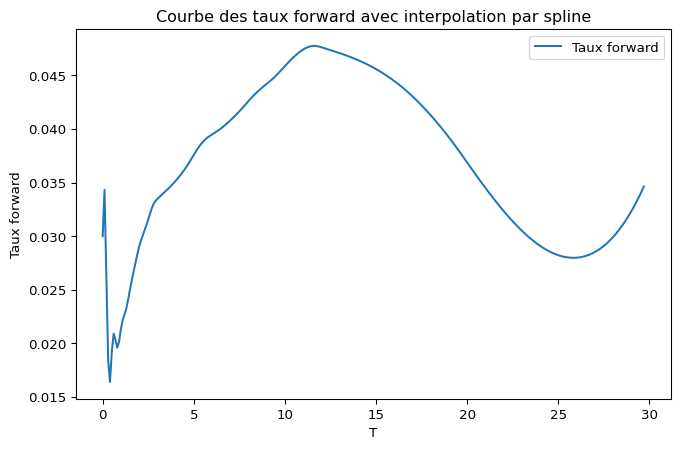

In [12]:
new_df_ZC= interpolate_and_update_df(df_ZC, 'T', 'R', kind='cubic', start=0, end=30, step=0.1)

tau = 0.25  # 3 mois = 0.25 an
fwd_rates = compute_forward_rates(new_df_ZC['R'], new_df_ZC['T'], tau)

plt.figure(figsize=(8, 5))
plt.plot(fwd_rates["T"],fwd_rates["tx_fwd"], label='Taux forward')
plt.xlabel('T')
plt.ylabel('Taux forward')
plt.legend()
plt.title('Courbe des taux forward avec interpolation par spline')

Lorsqu’on utilise une interpolation linéaire, on obtient une courbe plus
discontinue. La courbe a une structure en marches d’escalier. Il y a des
sauts brusques lorsque l’on passe d’un intervalle à un autre. En effet,
par nature, l’interpolation linéaire qui ne prend pas en compte les
points intermédiaires. En interpolant avec une fonction spline, on
obtient une courbe plus lisse et continue.Elle est plus cohérente avec
l’évolution naturelle des taux d’intérêt. En effet, la fonction spline
est une fonction polynomiale qui passe par tous les points de la courbe.
Elle est plus flexible et permet de mieux capturer les variations des
taux d’intérêt.

Nous sommes intéressés à ce qui pourrait se passer lorsque nous shiftons
le taux de swap 5Y de 10 points de base. Cela permet de déterminer la
sensibilité de la courbe des taux forward aux variations des taux de
swap et donc donner des indications sur comment hedger ce risque.

Nous allons donc calculer le taux forward 3M pour les deux courbes de
taux forward et comparer les résultats.

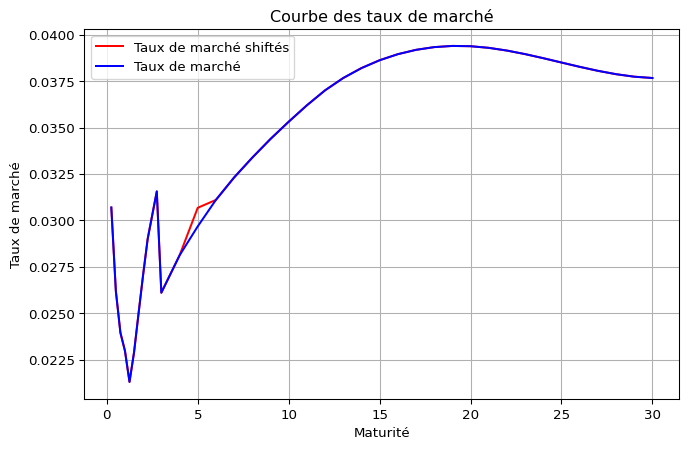

In [13]:
choc = 10/10000
new_df["tx_s"] = new_df.apply(lambda x: x['tx_h']+choc if x['T'] == 5 else x['tx_h'], axis=1)

# plot
plt.figure(figsize=(8, 5))
plt.plot(new_df["T"], new_df["tx_s"], label='Taux de marché shiftés', color="r")
plt.plot(new_df["T"], new_df["tx_h"], label='Taux de marché', color="b")
plt.xlabel('Maturité')
plt.ylabel('Taux de marché')
plt.title('Courbe des taux de marché')
plt.legend()
plt.grid()
plt.show()

new_df["tx_s"] = new_df.apply(lambda x: x['tx']+choc if x['T'] == 5 else x['tx'], axis=1)

Text(0.5, 1.0, 'Courbe de taux zéro coupon discrétisée')

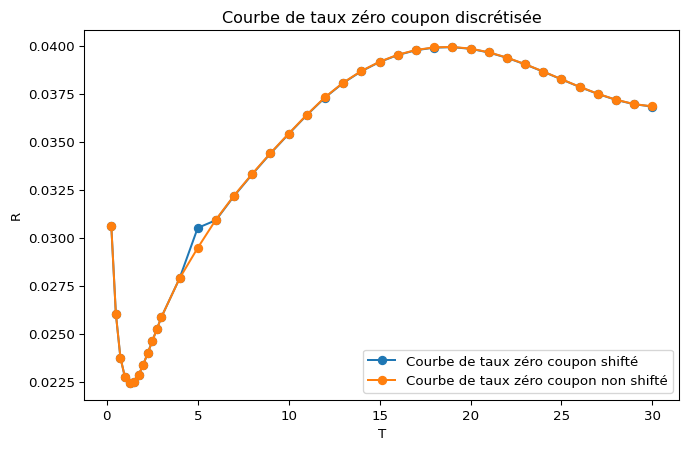

In [14]:
# Extraction des facteurs d'actualisation pour les Money Market
import numpy as np
import pandas as pd

def compute_discount_factors(new_df, col_T="T", col_tx="tx"):
    """
    Calcule les facteurs d'actualisation (B) et les taux zéro-coupon (R) 
    à partir des taux du marché pour les instruments MM, FUT et SWAP.

    Paramètres :
    - new_df : DataFrame contenant les taux du marché avec les colonnes spécifiées.
    - col_T : Nom de la colonne contenant les maturités (ex: "T").
    - col_tx : Nom de la colonne contenant les taux du marché (ex: "tx").

    Retourne :
    - df_ZC : DataFrame contenant les facteurs d'actualisation et les taux zéro-coupon.
    """

    # --- Extraction des données du marché monétaire (MM) ---
    mm = new_df[new_df['type'] == 'MM'].copy()
    mm.loc[:, 'B'] = 1 / (1 + mm[col_tx] * mm[col_T])
    mm.loc[:, 'R'] = - np.log(mm['B']) / mm[col_T]

    df_ZC = mm.copy()

    # --- Extraction des données Futures (FUT) ---
    fut = new_df[new_df['type'] == 'FUT'].copy()
    df_ZC = pd.concat([df_ZC, fut], ignore_index=True)

    mm_len = len(mm)

    # --- Calcul des facteurs d'actualisation pour les Futures ---
    for i in range(mm_len, len(df_ZC)):
        df_ZC.loc[i, 'B'] = df_ZC.loc[i-1, 'B'] / (1 + (1 - df_ZC.loc[i, col_tx]) * 0.25)
        df_ZC.loc[i, 'R'] = - np.log(df_ZC.loc[i, 'B']) / df_ZC.loc[i, col_T]

    # --- Extraction des données Swaps (SWAP) ---
    swap = new_df[new_df['type'] == 'SWAP'].copy()
    fut_len = len(fut)
    df_ZC = pd.concat([df_ZC, swap], ignore_index=True)

    # --- Calcul des facteurs d'actualisation pour les Swaps ---
    for i in range(mm_len + fut_len, len(df_ZC)):
        T_n = df_ZC.loc[i, col_T]  # Maturité actuelle
        mask = (df_ZC[col_T] < T_n) & (df_ZC[col_T] % 1 == 0)  # Sélection des T entiers < T_n

        sum_B = sum(df_ZC.loc[mask, 'B'].fillna(0))
        df_ZC.loc[i, 'B'] = (1 - df_ZC.loc[i, col_tx] * sum_B) / (1 + df_ZC.loc[i, col_tx])
        df_ZC.loc[i, 'R'] = - np.log(df_ZC.loc[i, 'B']) / T_n

    return df_ZC


df_ZC_s = compute_discount_factors(new_df, col_T="T", col_tx="tx_s")
df_ZC_s=pd.concat([pd.DataFrame({"T": [0], "B": [1], "R": [0]}), df_ZC_s], ignore_index=True)

plt.figure(figsize=(8, 5))
plt.plot(df_ZC_s.loc[1:,'T'], df_ZC_s.loc[1:,'R'], label='Courbe de taux zéro coupon shifté', marker='o')
plt.plot(df_ZC.loc[1:,"T"], df_ZC.loc[1:,"R"], label='Courbe de taux zéro coupon non shifté', marker='o')
plt.xlabel('T')
plt.ylabel('R')
plt.legend()
plt.title('Courbe de taux zéro coupon discrétisée')

Text(0.5, 1.0, 'Courbe des taux forward avec interpolation par spline')

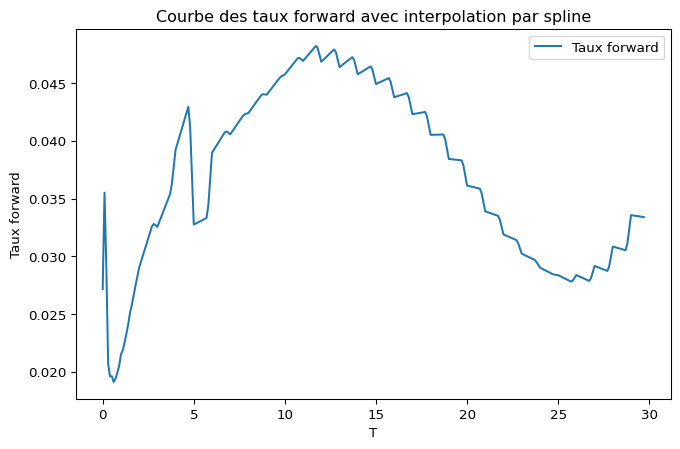

In [15]:
new_df_ZC= interpolate_and_update_df(df_ZC_s, 'T', 'R', kind='linear', start=0, end=30, step=0.1)

tau = 0.25  # 3 mois = 0.25 an
fwd_rates = compute_forward_rates(new_df_ZC['R'], new_df_ZC['T'], tau)

plt.figure(figsize=(8, 5))
plt.plot(fwd_rates["T"],fwd_rates["tx_fwd"], label='Taux forward')
plt.xlabel('T')
plt.ylabel('Taux forward')
plt.legend()
plt.title('Courbe des taux forward avec interpolation par spline')

Text(0.5, 1.0, 'Courbe des taux forward avec interpolation par spline')

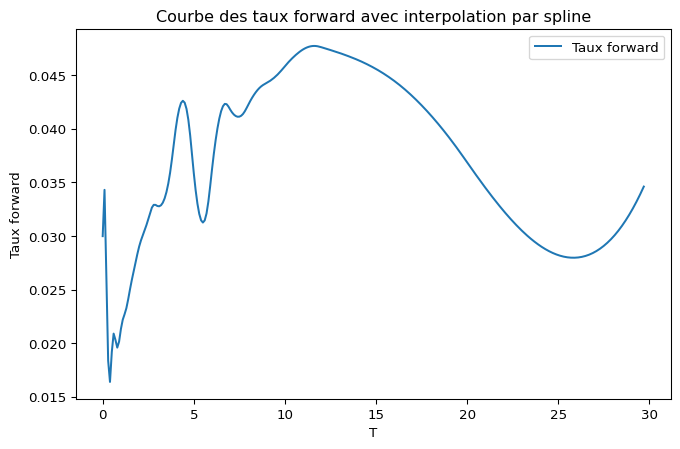

In [16]:
new_df_ZC= interpolate_and_update_df(df_ZC_s, 'T', 'R', kind='cubic', start=0, end=30, step=0.1)

tau = 0.25  # 3 mois = 0.25 an
fwd_rates = compute_forward_rates(new_df_ZC['R'], new_df_ZC['T'], tau)

plt.figure(figsize=(8, 5))
plt.plot(fwd_rates["T"],fwd_rates["tx_fwd"], label='Taux forward')
plt.xlabel('T')
plt.ylabel('Taux forward')
plt.legend()
plt.title('Courbe des taux forward avec interpolation par spline')

En shiftant le taux de swap 5Y, la courbe de forward baisse brusquement
pour T=5Y. Il y a une déformation locale de la courbe des taux forward.
Cela signifie que la courbe des taux forward est sensible aux variations
des taux de swap. En effet, les taux swap sont des instruments
financiers qui permettent de se couvrir contre les variations des taux
d’intérêt.

## II. Valorisation de swaptions et de caplets

1.  Pour coter les caplets/floorlets et swaptions, le modèle de Black
    est souvent utilisé. Ce modèle est basé sur l’hypothèse que les taux
    d’intérêt sont log-normalement distribués. Il permet de calculer le
    prix d’un caplet/floorlet et d’un swaption en fonction des taux
    d’intérêt et de la volatilité implicite.

2.  L’EDS (Equation Différentielle Stochastique) de Black est donnée par
    :

$$
dL(t) = \sigma L(t) dW(t)
$$

avec $L(t)$ le taux, $\sigma$ la volatilité du taux et $W(t)$ un
mouvement brownien. En utilisant le changement de numéraire, ce taux est
une martingale sous la mesure du numeraire (probabilité risque neutre).
Cela permet de calculer le prix d’un caplet/floorlet ou d’une swaption.

**Caplets et Floorlets**

1.  Pour un caplet, le prix est donné par la formule suivante :

$$
Caplet(t,T_{i-1},T_i) = N \delta_i B(t,T_i) \left[ L_i(t) \phi(d) - K \phi (d - \sigma_i \sqrt{T_{i-1}-t} )\right]
$$

avec
$d = \frac{1}{\sigma \sqrt{T_{i-1}-t}} \left( \ln \left( \frac{L_i(t)}{K} \right) + \frac{\sigma^2(T_{i-1}-t)}{2} \right)$,
$L_i(t)$ le taux forward 3M à la date t, $K$ le strike du caplet, $N$ le
nominal, $\delta_i$ la période de capitalisation, $B(t,T_i)$ le facteur
d’actualisation à la maturité $T_i$, $\sigma_i$ la volatilité du taux
forward 3M à la maturité $T_i$ et $\phi$ la fonction de répartition de
la loi normale standard.

Pour un floorlet, le prix est donné par la formule suivante :

$$
Floorlet(t,T_{i-1},T_i) = N \delta_i B(t,T_i) \left[ K \phi (d - \sigma_i \sqrt(T_{i-1}-t) ) - L_i(t) \phi(d) \right]
$$

**Swaptions**

Pour un swaption donneur, le prix est donné par la formule suivante :

$$
\text{Swaption}_t = \left( \sum_{j=1}^{n} N \delta B(t, T_j) \right) \left[ F_S(t) \Phi(d) - K \Phi(d - \sigma_S \sqrt{T_0 - t}) \right]
$$

avec $F_S(t)$ le taux swap à la date t, $K$ le strike du swaption, $N$
le nominal, $\delta$ la période de capitalisation, $B(t,T_j)$ le facteur
d’actualisation à la maturité $T_j$, $\sigma_S$ la volatilité du taux
swap et $\Phi$ la fonction de répartition de la loi normale standard.

d est donné par la formule suivante :

$$
d = \frac{1}{\sigma_S \sqrt{T_0 - t}} \left( \ln \left( \frac{F_S(t)}{K} \right) + \frac{\sigma_S^2(T_0 - t)}{2} \right)
$$

Pour un swaption receveur, le prix est donné par la formule suivante :

$$
\text{Swaption}_t = \left( \sum_{j=1}^{n} N \delta B(t, T_j) \right) \left[ K \Phi(d - \sigma_S \sqrt{T_0 - t}) - F_S(t) \Phi(d) \right]
$$

Il s’agit, à partir des cotations décrites dans le tableau ci-dessous et
de la courbe des taux zéro-coupon construite précédemment, calculer les
prix de marché de caplets sur euribor12M, ce qui implique une période de
capitalisation annuelle, de maturité T = 5Y, i.e. payé à 6Y, et de
strikes K associés au tableau. Nous souhaitons ainsi calculer : - Le
prix des caplets Caplet(t, 5Y, 6Y) pour les strikes du tableau
ci-dessous. - Le prix des swaptions Swaption(t, 5Y, 6Y) pour les strikes
du tableau ci-dessous.

In [17]:
vol_data = pd.read_excel('data/Data_tx.xlsx', sheet_name='vol')
vol_data

In [18]:
import numpy as np
from scipy.stats import norm

def price_oplet(N, delta_i, B_t_Ti, L_i_t, K, sigma_i, Ti, t, option_type='caplet'):
    """
    Calcule la valeur d'un caplet selon le modèle de Black.

    Paramètres :
    - N : Notional
    - delta_i : Période du caplet 
    - B_t_Ti : Facteur d'actualisation B(t, Ti)
    - L_i_t : Taux forward Li(t)
    - K : Strike du caplet
    - sigma_i : Volatilité implicite
    - Ti_1 : Date de début de la période
    - Ti : Date de fin de la période
    - t : Temps actuel

    Retourne :
    - Valeur du caplet
    """
    Ti_1 = Ti - delta_i
    d1 = (np.log(L_i_t / K) + 0.5 * sigma_i**2 * (Ti_1 - t)) / (sigma_i * np.sqrt(Ti_1 - t))
    d2 = sigma_i * np.sqrt(Ti_1 - t) - d1
    if option_type == 'caplet':
        price = N * delta_i * B_t_Ti * (L_i_t * norm.cdf(d1) - K * norm.cdf(-d2))
    elif option_type == 'floorlet':
        price = N * delta_i * B_t_Ti * (K * norm.cdf(d2) - L_i_t * norm.cdf(-d1))
    return price

for i in vol_data.index:
    # Notional
    N = 1  

    # Période du caplet
    delta_i = 1 

    # Maturité du caplet
    T=5 

    # Facteur d'actualisation B(t, Ti)
    B_t_Ti = df_ZC.loc[df_ZC['T'] == T+1, 'B'].values[0]

    # Taux forward Li(t)
    L_i_t = (1/delta_i) * ((df_ZC.loc[df_ZC['T'] == T, 'B'].values[0]/df_ZC.loc[df_ZC['T'] == T+1, 'B'].values[0]) - 1)

    # Strike du caplet
    K = L_i_t + vol_data.loc[i, 'Strike en bps et en rel. / fwd']/10000

    # Volatilité implicite
    sigma_i = vol_data.loc[i, "Vols Caplets"]  

    # Date de début de la période
    Ti = T + delta_i

    # Temps actuel
    t = 0  

    caplet_price = price_oplet(N, delta_i, B_t_Ti, L_i_t, K, sigma_i, Ti, t, option_type='caplet')
    vol_data.loc[i, 'Caplet Price MKT'] = caplet_price

vol_data

In [19]:
# pricer les swaptions

## III. Modèle de Hull-White

#### III.1 Du modèle HJM vers le modèle Hull&White

Pour une maturité $T$ fixée, Heath, Jarrow et Morton ont supposé que le
taux forward instantané évolue selon la dynamique suivante :

$$
df(t, T) = \alpha(t, T)\, dt + \sigma(t, T)\, dW_t \quad (1)
$$

La dynamique (1) ne se place pas forcément dans un cadre sans
opportunité d’arbitrage. Les auteurs ont montré que le processus
$\alpha$ ne pouvait pas être choisi arbitrairement et que, pour qu’il
existe une unique mesure martingale équivalente, $\alpha$ devait être
lié à la volatilité du zéro coupon.

Supposons donc l’existence d’une unique mesure martingale équivalente
$\mathbb{Q}$ (mesure risque-neutre) dont le numéraire est l’actif sans
risque.

On suppose que le prix du zéro coupon (payant une unité de devise en
date $T$) évolue sous $\mathbb{Q}$ selon l’EDS :

$$
\frac{dB(t, T)}{B(t, T)} = r_t\, dt + \Gamma(t, T)\, dW_t^Q \quad (2)
$$

Par définition, on sait que \$ B(t, T) = e^{-\_t^T f(t,s), ds}\$ et que
\$ f(t, T) = -\_T (B(t, T)). \$

En appliquant le lemme d’Itô, on obtient : \$ df(t, T) = (t, T), \_T (t,
T), dt - \_T (t, T), dW_t^Q. \$

En posant \$ -\_T (t, T) = (t, T), \$ nous obtenons :

$$
df(t, T) = \gamma(t, T) \int_t^T \gamma(t, u)\, du \, dt + \gamma(t, T)\, dW_t^Q \quad (3)
$$

Après intégration, on retrouve finalement :

$$
f(t, T) = f(0, T) + \int_0^t \gamma(s, T) \left( \int_s^T \gamma(s, u)\, du \right) ds + \int_0^t \gamma(s, T)\, dW_s^Q \quad (4)
$$

#### III.2 Hypothèses du modèle Hull&White

On suppose que le modèle HJM est gaussien, linéaire et calibrable. Ces
hypothèses permettent d’écrire :

$$
\gamma(t, T) = \sigma(t)\, e^{-\lambda (T-t)}  \quad \text{ et} \quad \Gamma(t, T) = \frac{\sigma(t)}{\lambda}\Bigl(e^{-\lambda (T-t)} - 1\Bigr)
$$

où la fonction de volatilité instantanée $\sigma(t)$ est constante par
morceaux.

#### III.3 Construction de la formule zéro-coupon

Dans le cadre du modèle Hull&White, la dynamique du taux court
instantané $r_t$ s’écrit :

$$
dr_t = \left[\lambda\bigl(f(0,t) - r_t\bigr) + \partial_t f(0,t) + \int_0^t \sigma^2(s)\, e^{-2\lambda (t-s)} ds \right] dt + \sigma(t)\, dW_t^Q \quad (5)
$$

On introduit alors une nouvelle variable d’état : \$ X_t = r_t -
f(0,t)\$

La dynamique de $X_t$ devient :

$$
dX_t = \left[\varphi(t) - \lambda X_t\right] dt + \sigma(t)\, dW_t^Q \quad (8)
$$

avec \$ (t) = \_0^t ^2(s), e^{-2(t-s)} ds. \$

La formule du prix du zéro coupon s’exprime alors comme une fonction
déterministe de $X_t$ :

$$
B(t, T) = \frac{B(0,T)}{B(0,t)} \exp\!\Biggl\{ -\frac{1}{2\beta^2(t,T)} \varphi(t) - \beta(t,T) X_t \Biggr\} \quad (9)
$$

où \$ (t, T) = . \$

1.  A quelle catégorie de modèle appartient le modèle Hull&White?
    Justifier.

Le modèle Hull & White est un modèle à structure à terme aﬃne, i.e. un
modèle de taux d’intérêt pour lequel le taux zéro-coupon continu R(t, T
) est une fonction aﬃne du taux court r (t).

Il ressemble à un processus d’Ornstein-Uhlenbeck ou mean reversing
process, qui est un processus gaussien définit de la manière suivante :

$$
dY_t = - \theta \left[Y_t - \mu \right] dt + \sigma dW_t,
$$

où $\theta, \mu, \sigma$ sont des paramètres déterministes et $W_t$ est
le processus de Wiener.

Dans notre cas, on a $\theta = \lambda$, $\mu = \frac{\phi(t)}{\lambda}$
et $\sigma = \sigma(t)$. De ce fait, la moyenne et la variance dépend du
temps et le paramètre de vitesse de retour à la moyenne est constant.

1.  Déterminer la loi du processus $X_t|X_s$?

Sous la probabilité risque neute $\mathbb{Q}$, le processus $X_t$
s’ecrit :

$$
dX_t = \left(\phi(t)- \lambda X_t \right) dt + \sigma(t) dW_t^Q,
$$

avec $\phi(t) = \int_0^t \sigma^2(s) e^{-2\lambda(t-s)} ds$.

Posons
$K_t = e^{\lambda t} X_t  = f(X_t, t)\implies X_t = e^{-\lambda t} K_t$,
par la formule d’Itô, on a :

De ce fait, on en déduit que \$X_t\|X_s ( X_s e^{-(t-s)} + \_s^t
e^{-(t-u)} (u) du, \_s^t e^{-2 (t-u)} (u)^2 d ) \$.

#### III.4 Dynamique des taux forwards

On note ensuite $L_i(t)$ le taux LIBOR forward à la date $t$ qui fixe en
$T_i$ et paie en $T_{i+1}$. Sous l’hypothèse d’absence d’opportunité
d’arbitrage, ce taux s’exprime à partir de la courbe de taux : Î $$
L_i(t) = \frac{1}{\delta_i}\left(\frac{B(t, T_i)}{B(t, T_{i+1})} - 1\right)  = \frac{1}{\delta_i}\left(Z_t- 1\right) ,
$$

Pour connaitre la dynamique des taux forwards, on applique le lemme
d’Itô au processus :

$$
Z_t = \frac{B(t, T_i)}{B(t, T_{i+1})}.
$$

Rappel du lemme d’Itô : Considérons deux actifs $X$ et $Y$ et posons
$Z = \frac{X}{Y}$ (la valeur de $X$ exprimée en numéraire $Y$). Le lemme
d’Itô nous donne l’évolution de $Z$ par :

$$
\frac{dZ}{Z} = \left(\frac{dX}{X} - \frac{dY}{Y}\right) - \left\langle \frac{dX}{X} - \frac{dY}{Y},\, \frac{dY}{Y}\right\rangle.
$$

En appliquant le lemme d’Itô à $Z_t$, on obtient :

avec

De ce fait, on a :

où $d\tilde{W_t}$ est un mouvement brownien selon le théorème de
Girsanov.

La diffusion de $Z_t$ est une loi log-normale, sans drift sous la
probabilité risque forward. De ce fait, il suit le modèle de Black pour
la valorisation des options.

On peut écrire ainsi la dynamique du taux forward $L_i(t)$ sous la
probabilité risque forward :

#### III.5 Valorisation des instruments de calibration

1.  **Payoff d’un caplet vanille :**  
    Le payoff d’un caplet sur le taux LIBOR $L_i(T_i)$, de maturité
    $T_i$, avec paiement en $T_{i+1}$ et de strike $K$ est donné par :

$$
\text{Payoff} = \delta_i\, \max\Bigl( L_i(T_i) - K,\; 0 \Bigr).
$$

1.  **Formule de valorisation dans le cadre du modèle H&W :**  
    Il peut être démontré que la formule de valorisation de ce caplet
    s’exprime de la manière suivante :

$$
C\Bigl( Z_t,\, \tilde{K},\, T_i,\, \sigma_i^*,\, B(t, T_{i+1}) \Bigr) \quad (11)
$$

avec :

-   \$ Z_t = \$,
-   \$ (\_i^\*)^2 = *t^{T_i} ( (s, T_i) - (s, T*{i+1}) )^2 ds = ^2(T_i,
    T\_{i+1}), (T_i) \$,
-   \$ = 1 + \_i K \$,
-   \$ C() \$ désigne le prix d’un Call selon le cadre Black, en
    fonction du forward, du strike, de la maturité, de la volatilité et
    du facteur d’actualisation.

En effet, on peut réécrire le payoff d’un caplet sous la forme d’un Call
sur $Z_t$ qui suit un modèle de Black :

### III.6. Calibration du modèle

Le modèle de Hull White permet d’avoir une formule fermée pour le prix
des caplets. De fait, puisqu’on a calculé les prix de marché de caplets
sur euribor12M, ce qui implique une période de capitalisation annuelle,
de maturité T = 5Y, nous pouvons desormais calibrer le paramètre de
volatilité $\sigma_i^*$ avec la méthode de dichotomie et aussi extraire
de manière analytique la volatilité instantanée $\sigma(t)$ du modèle
Hull&White, qu’on supposera constante, i.e. $\sigma(t) = \sigma$.

On pose également, pour la calibration, $\lambda = 5\%$.

Pour extraire la volatilité spot, nous utiliserons uniquement le prix de
marche ATM.

In [20]:
caplet_price_MKT = vol_data.loc[3, 'Caplet Price MKT']
print(f"Le prix de marché caplet sur euribor 12M de maturité T=5Y est de {caplet_price_MKT:.4%}")

Le prix de marché caplet sur euribor 12M de maturité T=5Y est de 0.7137%

In [21]:
import numpy as np
from scipy.stats import norm

def price_oplet_HW(N, delta_i, B_t_Ti, L_i_t, K, Ti, t, sigma_i, option_type='caplet', model='HW'):
    if model == "HW" :
        Z_t = delta_i * L_i_t + 1
        K = 1 + delta_i * K
        return price_oplet(N=N, delta_i=delta_i, B_t_Ti=B_t_Ti, L_i_t=Z_t, K=K, sigma_i=sigma_i, Ti=Ti, t=t, option_type=option_type)
    else:
        return price_oplet(N=N, delta_i=delta_i, B_t_Ti=B_t_Ti, L_i_t=L_i_t, K=K, sigma_i=sigma_i, Ti=Ti, t=t, option_type=option_type)

In [22]:
def Dichotomie(N, delta_i, B_t_Ti, L_i_t, K, Ti, t,caplet_price_MKT,option_type='caplet', model="HW",tol=1e-6, sigma_low=1/10000, sigma_high=1):
    """
    Extrait la volatilité implicite sigma en utilisant la méthode de dichotomie.
    """
    fmin = price_oplet_HW(N, delta_i, B_t_Ti, L_i_t, K, Ti, t, sigma_low, option_type=option_type, model=model)
    fmax = price_oplet_HW(N, delta_i, B_t_Ti, L_i_t, K, Ti, t, sigma_high,option_type=option_type, model=model)
    price = caplet_price_MKT
    if fmin>price :
        return sigma_low
    elif fmax<price :
        return sigma_high
    else:
        while sigma_high-sigma_low>tol:
            sigma_mid = (sigma_low + sigma_high) / 2
            fmin = price_oplet_HW(N, delta_i, B_t_Ti, L_i_t, K, Ti, t, sigma_low, option_type=option_type, model=model)
            fmid = price_oplet_HW(N, delta_i, B_t_Ti, L_i_t, K, Ti, t, sigma_mid,option_type=option_type, model=model)
            if ((fmin - price) * (fmid - price) > 0) : # jette la moitié de gauche
                sigma_low = sigma_mid
            else: # jette la moitié de droite
                sigma_high = sigma_mid
        sigma_mid = (sigma_low + sigma_high) / 2
        return sigma_mid
    

# Notional
N = 1  

# Période du caplet
delta_i = 1 

# Maturité du caplet
Ti=6

# Facteur d'actualisation B(t, Ti)
B_t_Ti = df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0]

# Taux forward Li(t)
L_i_t = (1/delta_i) * ((df_ZC.loc[df_ZC['T'] == Ti-1, 'B'].values[0]/df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0]) - 1)

# Strike du caplet
K = L_i_t + vol_data.loc[3, 'Strike en bps et en rel. / fwd']/10000

lambda_ = 5/100

sigma_i = Dichotomie(N, delta_i, B_t_Ti, L_i_t, K, Ti, t,caplet_price_MKT, option_type='caplet',model="HW")
print("Volatilité implicite (en %) :", sigma_i*100) 

Volatilité implicite (en %) : 0.9271045541763303

In [23]:
beta_Ti_Ti_1 =  ((1 - np.exp(- lambda_ * delta_i))/lambda_)**2
Ti_1 = Ti - delta_i
phi = (1 - np.exp(-2*lambda_*(Ti_1-t)))/(2*lambda_)
sigma = np.sqrt((sigma_i**2 * Ti_1)/ (beta_Ti_Ti_1 * phi))

print("Volatilité instantanée (en %) :", sigma*100) 

Volatilité instantanée (en %) : 1.071446257025021

1.  Cette volatilité spot nous permet de valoriiser les caplets pour des
    strikes différents de l’ATM à l’aide de la formule de valorisation
    fermée du modèle Hull et White.

In [24]:
for i in vol_data.index:
    # Notional
    N = 1  

    # Période du caplet
    delta_i = 1 

    # Maturité du caplet
    Ti=6

    # Facteur d'actualisation B(t, Ti)
    B_t_Ti = df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0]

    # Taux forward Li(t)
    L_i_t = (1/delta_i) * ((df_ZC.loc[df_ZC['T'] == Ti-1, 'B'].values[0]/df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0]) - 1)

    # Strike du caplet
    K = L_i_t + vol_data.loc[i, 'Strike en bps et en rel. / fwd']/10000

    sigma_i = sigma_i

    lambda_ = 5/100

    caplet_price = price_oplet_HW(N, delta_i, B_t_Ti, L_i_t, K, Ti, t, sigma_i, option_type='caplet', model='HW')
    vol_data.loc[i, 'Caplet Price HW'] = caplet_price

vol_data

L’une des faiblesses du modèle de Hull et White est le fait qu’il
n’arrive pas à capter le smile de volatilité. En effet, la volatilité
implicite extraite est un skew. Pour constater ce phénomène, nous
inverserons la formule de Black pour les caplets et nous en déduirons la
volatilité implicite pour chaque strike. Nous utiliserons toujours la
méthode de dichotomie pour trouver la volatilité implicite.

In [25]:
for i in vol_data.index:
    N = 1
    delta_i = 1
    Ti = 6
    B_t_Ti = df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0]
    L_i_t = (1 / delta_i) * ((df_ZC.loc[df_ZC['T'] == Ti-1, 'B'].values[0] / df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0]) - 1)
    K = L_i_t + vol_data.loc[i, 'Strike en bps et en rel. / fwd'] / 10000
    lambda_ = 5 / 100
    caplet_price_MKT = vol_data.loc[i, 'Caplet Price HW']

    sigma_extracted =  Dichotomie(N, delta_i, B_t_Ti, L_i_t, K, Ti, t, caplet_price_MKT, option_type='caplet', model='Black')
    vol_data.loc[i, 'Sigma_HW'] = sigma_extracted

vol_data

Text(0, 0.5, 'Volatilité')

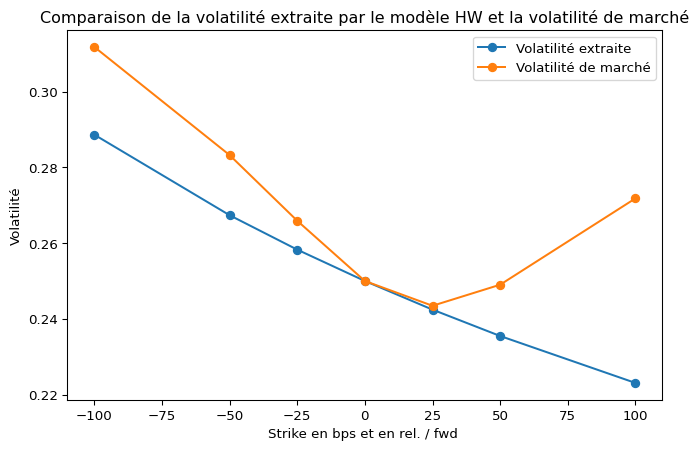

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(vol_data["Strike en bps et en rel. / fwd"], vol_data["Sigma_HW"], label='Volatilité extraite', marker='o')
plt.plot(vol_data["Strike en bps et en rel. / fwd"], vol_data["Vols Caplets"], label='Volatilité de marché', marker='o')
plt.legend()
plt.title('Comparaison de la volatilité extraite par le modèle HW et la volatilité de marché')
plt.xlabel('Strike en bps et en rel. / fwd ')
plt.ylabel('Volatilité')

In [27]:
ATM  = L_i_t

### 3.7 Valorisation d’un produit structuré

Remarques préliminaires :

-   Nous garderons dans un premier temps la calibration ATM effectuée
    avec $\lambda = 5\%$.
-   Pour la partie Monte-Carlo, nous admettrons que l’EDS pour le
    processus $X_t$ sous la probabilité forward neutre $Q^T$ associée au
    numéraire $B(t,T)$ s’écrit comme :

$$
dX_t = \left[\phi(t) + \sigma(t)\Gamma(t,T) - \lambda X_t\right] dt + \sigma(t) dW_t^T \tag{12}
$$

Où $W_t^T$ est un brownien sous $Q^T$.

Nous souhaitons valoriser un caplet de strike $K$, de dates de fixing
$T_i = 5Y$ et de paiement $T_{i+1} = 6Y$ et de barrière désactivante $B$
(avec $B > K$).

1.  Écrire le payoff de l’option et tracer la fonction de payoff en
    fonction de $L_i(T_i)$. Cette option est-elle plus ou moins chère
    qu’un simple caplet de strike $K$ ?

Le payoff de l’option est donné par :

$$
\text{Payoff} = \delta_i\, \max\Bigl( L_i(T_i) - K,\; 0 \Bigr) \mathbb{1}_{L_i(T_i) < B}
$$

<figure>
<img src="attachment:image-2.png" alt="image-2.png" />
<figcaption aria-hidden="true">image-2.png</figcaption>
</figure>

Il est possible de décomposer le payoff à partir d’options vanilles et
digitales :

$$
\text{Payoff} = C_K - CB - (B-K) \times D_B
$$

Une option digitale est une option qui paie 1 si le sous-jacent est
au-dessus d’un certain seuil et 0 sinon. De ce fait, le payoff de
l’option est donné par :

$$
D_B = \delta_i\, \max\Bigl( L_i(T_i) - K,\; 0 \Bigr) \mathbb{1}_{L_i(T_i) > K} 
$$

<figure>
<img src="attachment:image.png" alt="image.png" />
<figcaption aria-hidden="true">image.png</figcaption>
</figure>

Une option vanille est un contrat financier standardisé qui donne le
droit, mais non l’obligation, d’acheter (call) ou de vendre (put) un
actif sous-jacent à un prix fixé (strike) à une date donnée (maturité).
De ce fait, dans le cas d’un call, le payoff de l’option est donné par :

$$
C_K = \delta_i\, \max\Bigl( L_i(T_i) - K,\; 0 \Bigr)
$$

<figure>
<img src="attachment:Capture%20d’écran%202025-03-05%20à%2000.17.09.png"
alt="Capture d’écran 2025-03-05 à 00.17.09.png" />
<figcaption aria-hidden="true">Capture d’écran 2025-03-05 à
00.17.09.png</figcaption>
</figure>

1.  Rappeler les principes du pricing par méthode de Monte-Carlo.

La méthode de Monte-Carlo est une méthode numérique qui permet de pricer
des produits financiers complexes lorsque les formules fermées ne sont
pas disponibles. Elle consiste à simuler un grand nombre $N$ de
trajectoires du processus stochastique et à calculer la moyenne
empiriques des payoffs actualisés pour obtenir le prix de l’option.

1.  Rappeler comment on simule une loi gaussienne à partir d’une loi
    uniforme.

Pour simuler une variable aléatoire suivant une loi gaussienne standard
$\mathcal{N}(0,1)$ à partir d’une variable uniforme $U$ sur $[0,1]$, on
applique l’**inverse de la fonction de répartition de la loi gaussienne
standard** (aussi appelée la fonction quantile de la loi normale) :

$$
X = F^{-1}(U)
$$

où $F$ est la fonction de répartition de la loi normale standard.

1.  On considère un caplet sur euribor12M à barrière désactivante de
    strike \$ K = ATM - 100 bps\$, de barrière $B = ATM + 100 bps$ et de
    maturité $T_i = 5Y$. Pour valoriser cette option, nous allons
    utiliser une méthode numérique de type Monte-Carlo. Pour cela, il
    est necessaire de connaire la loi de X_t sachant X_s. En nous aidant
    de la question précédente, on peut déduire que la loi de $X_t|X_s$
    est une loi normale de paramètres :

$$
X_t|X_s \sim \mathcal{N}\left( X_s e^{-\lambda (t-s)} + \int_s^t e^{-\lambda (t-u)} \left( \phi(u) - \sigma \Gamma(u,T) \right) du, \quad \int_s^t e^{-2 \lambda (t-u)} \sigma^2 d \right) 
$$

Pour valoriser cette option, nous pouvons directement utiliser la loi de
$X_5|X_0$ pour simuler les trajectoires du taux court et calculer le
payoff de l’option ou diffuser progressivement le taux court en
utilisant la loi de $X_t|X_s$ pour chaque pas de temps. Ensuite, il
s’agira de calculer le payoff de l’option à chaque date, en faire la
moyenne et l’actualiser pour obtenir le prix de l’option.

##### Méthode 1 : Simulation de la loi de $X_5|X_0$

In [28]:
import numpy as np
from scipy.integrate import quad

# Fonction phi(t) - variance cumulée
def phi(t, sigma, lambda_):
    return (sigma**2 / (2 * lambda_)) * (1 - np.exp(-2 * lambda_ * t))

# Fonction beta(t, T)
def beta(t, T, lambda_):
    return (1 - np.exp(-lambda_ * (T - t))) / lambda_

# Fonction gamma(t, T)
def gamma(t, T, sigma, lambda_):
    return (sigma / lambda_) * (np.exp(-lambda_ * (T - t)) - 1)

# Fonction B(t, T)
def B_t_T(t, T, B0_T, B0_t, X_t, sigma, lambda_):
    beta_t_T = beta(t, T, lambda_)**2
    phi_t = phi(t, sigma, lambda_)
    exponent = -0.5 * beta_t_T * phi_t - beta_t_T * X_t
    return (B0_T / B0_t) * np.exp(exponent)

# Fonction d'intégration avec paramètres supplémentaires
def integrand_mean(u, t, Xs, s, sigma, lambda_, T):
    # t = borne sup
    # s = borne inf
    # T = maturité
    Xt = Xs * np.exp(-lambda_ * (t - s))
    exp_part = np.exp(-lambda_ * (t - u))
    return Xt + exp_part * (phi(u, sigma, lambda_) + sigma * gamma(u, T, sigma, lambda_))

# Paramètres
T = Ti_1  = 5
Xs = X0 = 0  
s = 0
t = Ti_1 

# Calcul de la moyenne conditionnelle
mean_5_given_0, _ = quad(integrand_mean, s, t, args=(t, Xs, s, sigma, lambda_, T))
print(f"Moyenne conditionnelle de X_5 | X_0 : {mean_5_given_0:.6f}")

# Calcul de la variance conditionnelle (indépendant de gamma ici)

def compute_variance(sigma, lambda_, t, s):
    return (sigma**2) * (1 - np.exp(-2 * lambda_ * (t - s))) / (2 * lambda_)
var_5_given_0 = compute_variance(sigma, lambda_, t, s)
# var_5_given_0 = (sigma**2) * (1 - np.exp(-2 * lambda_ * (t - s))) / (2 * lambda_)
print(f"Variance conditionnelle de X_5 | X_0 : {var_5_given_0:.6f}")

Moyenne conditionnelle de X_5 | X_0 : 0.000000
Variance conditionnelle de X_5 | X_0 : 0.000452

In [29]:
Ti_1 = 5
Ti = 6

# Simulation Monte Carlo
n_simulations = 10000

payoffs = np.zeros(n_simulations)
for sim in range(n_simulations):
    phi_ = phi(Ti_1, sigma, lambda_)
    gamma_ = gamma(Ti_1,Ti, sigma, lambda_)

    # Moyenne
    mu_X = mean_5_given_0

    # Ecart-type
    sigma_X = np.sqrt(var_5_given_0)

    # X_5|X_0
    X = np.random.normal(mu_X, sigma_X)  

    # Calcul du prix B(5,6) selon Hull-White
    B0_6 = df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0] # B(0,6)
    B0_5 = df_ZC.loc[df_ZC['T'] == Ti_1, 'B'].values[0] # B(0,5)

    B_5_6 = B_t_T(5, 6, B0_6, B0_5, X, sigma, lambda_)
    B_5_5 = B_t_T(5, 5, B0_5, B0_5, X, sigma, lambda_)

    # Calcul du taux forward L_i_t
    L_i_t = ((B_5_5 / B_5_6) - 1)
    bp = 100/10000

    # Définition du strike
    strike = ATM - bp

    # Barrière
    B = ATM + bp

    # Payoff de l'option
    payoff = np.maximum(L_i_t - strike, 0) * (L_i_t < B)
    payoffs[sim] = payoff

# Prix de l'option call
call_price = B0_6 * np.mean(payoffs)
print(f"Prix du call : {call_price:.6f}")

Prix du call : 0.002970

##### Méthode 2 : Methode de diffusion

In [30]:
# Simulation Monte Carlo
n_simulations = 10000

payoffs = np.zeros(n_simulations)
X0 = 0
Ti = 6
Ti_1 = 5
X = np.zeros(Ti)
X[0] = X0

for sim in range(n_simulations):
    phi_ = phi(Ti_1, sigma, lambda_)
    gamma_ = gamma(Ti_1,Ti, sigma, lambda_)

    for i in range(1,Ti):
        t = i
        s = i-1
        T = 5 
        Xs = X[i-1]

        # Calcul de la moyenne conditionnelle
        mu_X, _ = quad(integrand_mean, s, t, args=(t, Xs, s, sigma, lambda_, T))
        sigma_X = np.sqrt(compute_variance(sigma, lambda_, t, s))
        X[i] = np.random.normal(mu_X, sigma_X)

    # Calcul du prix B(5,6) selon Hull-White
    B0_6 = df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0] # B(0,6)
    B0_5 = df_ZC.loc[df_ZC['T'] == Ti_1, 'B'].values[0] # B(0,5)

    B_5_6 = B_t_T(5, 6, B0_6, B0_5, X[Ti_1], sigma, lambda_)
    B_5_5 = B_t_T(5, 5, B0_5, B0_5, X[Ti_1], sigma, lambda_)

    # Calcul du taux forward L_i_t
    L_i_t = ((B_5_5 / B_5_6) - 1)
    bp = 100/10000

    # Définition du strike
    strike = ATM - bp

    # Barrière
    B = ATM + bp

    # Payoff de l'option
    payoff = np.maximum(L_i_t - strike, 0) * (L_i_t < B)
    payoffs[sim] = payoff

# Prix de l'option call
call_price = B0_6 * np.mean(payoffs)
print(f"Prix du call : {call_price:.6f}")

Prix du call : 0.003026

Nous constatons qu’avec les deux méthodes, nous obtenons des prix
d’options similaires (différent de 0.2bps). Cela confirme que les deux
méthodes convergent vers le même résultat.

En dégénérant le produit en faisant tendre la barrière à $+\infty$, nous
constatons que le prix de l’option call est égal au prix de marché du
forward. En dégénérant le produit en faisant tendre la barrière à 0,
nous constatons que le prix de l’option call est égal à 0.

Cela est cohérent car lorsque la barrière est très élevée, le produit
est équivalent à un forward et lorsque la barrière est nulle, le produit
est équivalent à un call classique. La fonction que nous avons
implémenté est donc cohérente et bien implémentée.

In [31]:
Ti_1 = 5
Ti = 6

# Simulation Monte Carlo
n_simulations = 10000

payoffs = np.zeros(n_simulations)
for sim in range(n_simulations):
    phi_ = phi(Ti_1, sigma, lambda_)
    gamma_ = gamma(Ti_1,Ti, sigma, lambda_)

    # Moyenne
    mu_X = mean_5_given_0

    # Ecart-type
    sigma_X = np.sqrt(var_5_given_0)

    # X_5|X_0
    X = np.random.normal(mu_X, sigma_X)  

    # Calcul du prix B(5,6) selon Hull-White
    B0_6 = df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0] # B(0,6)
    B0_5 = df_ZC.loc[df_ZC['T'] == Ti_1, 'B'].values[0] # B(0,5)

    B_5_6 = B_t_T(5, 6, B0_6, B0_5, X, sigma, lambda_)
    B_5_5 = B_t_T(5, 5, B0_5, B0_5, X, sigma, lambda_)

    # Calcul du taux forward L_i_t
    L_i_t = ((B_5_5 / B_5_6) - 1)
    bp = 100/10000

    # Définition du strike
    strike = ATM # - bp

    # Barrière
    B = np.inf#ATM + bp

    # Payoff de l'option
    payoff = np.maximum(L_i_t - strike, 0) * (L_i_t < B)
    payoffs[sim] = payoff

# Prix de l'option call
call_price = B0_6 * np.mean(payoffs)
print(f"Prix du call : {call_price:.6f}")

Prix du call : 0.007296

Nous rendons la barrière ‘bermudéenne’ en étendant la condition de
désactivation aux dates 1Y, 2Y, 3Y, 4Y et 5Y. De ce fait, le payoff de
cette option s’écrit :

$$
\text{Payoff} = \delta_i \max\Bigl( L_i(T_i) - K,\; 0 \Bigr) \mathbb{1}_{max_{i=1,\dots,5}(L_i(T_i) < B)}
$$

In [32]:
# Option bermudienne

# Simulation Monte Carlo
n_simulations = 10000

payoffs = np.zeros(n_simulations)
X0 = 0
Ti = 6
Ti_1 = 5
X = np.zeros(Ti)
X[0] = X0

for sim in range(n_simulations):
    phi_ = phi(Ti_1, sigma, lambda_)
    gamma_ = gamma(Ti_1,Ti, sigma, lambda_)
    L_i_t = np.zeros(Ti_1)
    for i in range(1,Ti):
        t = i
        s = i-1
        T = 5 
        Xs = X[s]

        # Calcul de la moyenne conditionnelle
        mu_X, _ = quad(integrand_mean, s, t, args=(t, Xs, s, sigma, lambda_, T))
        sigma_X = np.sqrt(compute_variance(sigma, lambda_, t, s))
        X[i] = np.random.normal(mu_X, sigma_X)

        # Calcul du prix B(5,6) selon Hull-White
        Bi_t = df_ZC.loc[df_ZC['T'] == t, 'B'].values[0] # B(0,6)
        Bi_s = df_ZC.loc[df_ZC['T'] == s, 'B'].values[0] # B(0,5)

        B_s_t = B_t_T(s, t, Bi_t, Bi_s, X[i], sigma, lambda_)
        B_s_s = B_t_T(s, s, Bi_s, Bi_s, X[i], sigma, lambda_)

        # Calcul du taux forward L_i_t
        L_i_t[i-1] = (1 / (t-s)) * ((B_s_s / B_s_t) - 1)
    
    # Calcul du prix B(5,6) selon Hull-White
    B0_6 = df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0] # B(0,6)
    B0_5 = df_ZC.loc[df_ZC['T'] == Ti_1, 'B'].values[0] # B(0,5)

    B_5_6 = B_t_T(5, 6, B0_6, B0_5, X[Ti_1], sigma, lambda_)
    B_5_5 = B_t_T(5, 5, B0_5, B0_5, X[Ti_1], sigma, lambda_)

    # Calcul du taux forward L_i_t
    L_t = ((B_5_5 / B_5_6) - 1)
    bp = 100/10000


    # Définition du strike
    strike = ATM - bp

    # Barrière
    B = ATM + bp

    # Payoff de l'option
    payoff = np.maximum(L_t - strike, 0) * (np.max(L_i_t) < B)
    payoffs[sim] = payoff

# Prix de l'option call
call_price = B0_6 * np.mean(payoffs)
print(f"Prix du call : {call_price:.6f}")

Prix du call : 0.003020

L’un des paramètres important du modèle de Hull et White est la mean
reversion $\lambda$, qui caractérise la force de rappel à la moyenne du
processus. Ce paramètre a un impact positive sur la valorisation de
l’option, comme nous pouvons l’observer dans la figure ci dessous .

In [33]:
# Liste des lambda à tester
lambdas = np.linspace(0.01, 1, 15)  # Exemple de grille de lambda
results = []

Ti_1 = 5
Ti = 6
# Boucle principale sur les lambdas
for lambda_ in lambdas:
    n_touched = 0
    payoffs = np.zeros(n_simulations)

    for sim in range(n_simulations):
        phi_ = phi(Ti_1, sigma, lambda_)
        gamma_ = gamma(Ti_1,Ti, sigma, lambda_)

        # Moyenne
        mu_X = mean_5_given_0

        # Ecart-type
        sigma_X = np.sqrt(var_5_given_0)

        # X_5|X_0
        X = np.random.normal(mu_X, sigma_X)  

        # Calcul du prix B(5,6) selon Hull-White
        B0_6 = df_ZC.loc[df_ZC['T'] == Ti, 'B'].values[0] # B(0,6)
        B0_5 = df_ZC.loc[df_ZC['T'] == Ti_1, 'B'].values[0] # B(0,5)

        B_5_6 = B_t_T(5, 6, B0_6, B0_5, X, sigma, lambda_)
        B_5_5 = B_t_T(5, 5, B0_5, B0_5, X, sigma, lambda_)

        L_i_t = ((B_5_5 / B_5_6) - 1)
        bp = 100 / 10000
        strike = ATM - bp
        B = ATM + bp

        payoff = np.maximum(L_i_t - strike, 0) * (L_i_t < B)
        payoffs[sim] = payoff

        # Vérification de la barrière
        if np.any(L_i_t>= B):
            n_touched += 1

    prob_toucher_barriere = n_touched / n_simulations

    call_price = B0_6 * np.mean(payoffs)
    results.append((lambda_, call_price,prob_toucher_barriere))

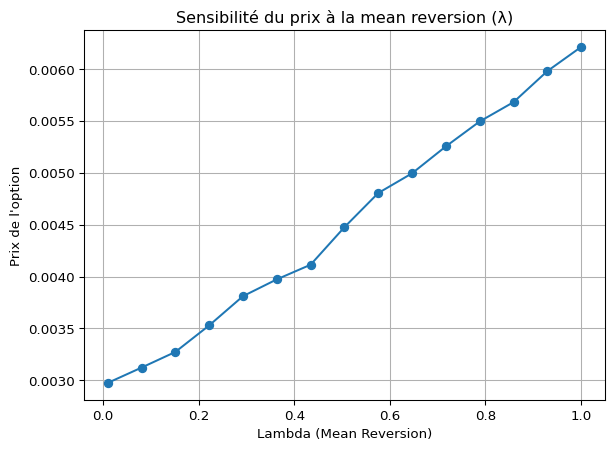

In [34]:
# Optionnel : Graphique de la sensibilité
import matplotlib.pyplot as plt

lambdas, prices, probabilities = zip(*results)
plt.plot(lambdas, prices, marker='o')
plt.xlabel('Lambda (Mean Reversion)')
plt.ylabel('Prix de l\'option')
plt.title('Sensibilité du prix à la mean reversion (λ)')
plt.grid(True)
plt.show()

De plus, plus le paramètre de mean reversion $\lambda$ est élevé, plus
la probabilité de toucher la barrière est faible. Inversement, une
faible mean reversion laisse plus de liberté au processus pour explorer
des valeurs extrêmes, augmentant ainsi la probabilité de franchir la
barrière.

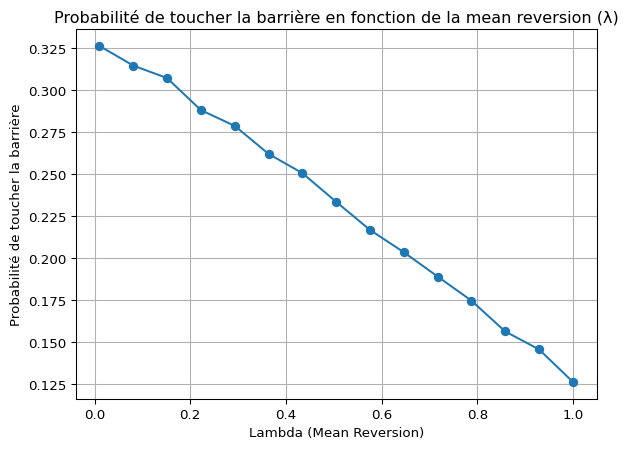

In [35]:
plt.plot(lambdas, probabilities, marker='o')
plt.xlabel('Lambda (Mean Reversion)')
plt.ylabel('Probabilité de toucher la barrière')
plt.title('Probabilité de toucher la barrière en fonction de la mean reversion (λ)')
plt.grid(True)
plt.show()